# Практика №5

In [1]:
import iapws
from iapws import IAPWS97 as gas

In [2]:
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

## Задача 4.1 

Определить расход пара на входе в турбину (G0) и в конденсатор (Gк) для турбины с промежуточным перегревом пара



Исходными данными для расчетов являются: электрическая мощность ПТУ NЭ, параметры свежего пара (р0, t0) и после промперегревателя (рпп, tпп), давление в конденсаторе рк, число регенеративных подогревателей Z, а также температура питательной воды (tпв»230-245оC при р0=12,8 МПа и tпв»263-275оC при р0=23,5 МПа). Принять давление питательной воды рпв=(1,37-1,4) р0 при докритических параметрах свежего пара и рпв=(1,33-1,35)р0 при сверхкритических параметрах свежего пара.

При построении процесса расширения в турбине учесть потери давления:

- в стопорных и регулирующих клапанах ЦВД $\Delta$р0=0,05р0;

- в промежуточном пароперегревателе d $\Delta$рпп=0,08рпп;

- в стопорных и регулирующих клапанах ЦСД $\Delta$р=0,03рпп.

Принять, что в выходном патрубке ЦНД турбины энергия с выходной скоростью за последней ступенью затрачивается на преодоление аэродинамического сопротивления каналов патрубка, т.е. р2=рк.

Принять нагрев питательной воды в питательном насосе относительно температуры по состоянию насыщения в деаэраторе 4-7оС. При этом нижняя граница диапазона температур назначается для ПЭН (в условиях докритических параметров свежего пара), а верхняя - для ПТН (в условиях сверхкритических параметров свежего пара).

Допускается КПД для цилиндров принимать в диапазоне:
$$\eta_{oi}^{ЦВД}=0,82…0,87 \space; \eta_{oi}^{ЦСД}=0,86…0,92 \space; \eta_{oi}^{ЦНД}=0,78…0,83 $$

Примем $\eta_{oi}^{ЦВД} = \eta_{oi}^{ЦСД} = \eta_{oi}^{ЦНД} = 0.85$

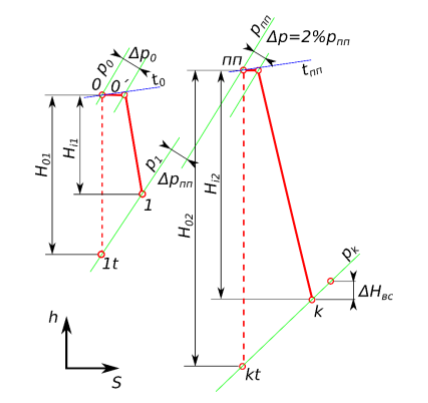

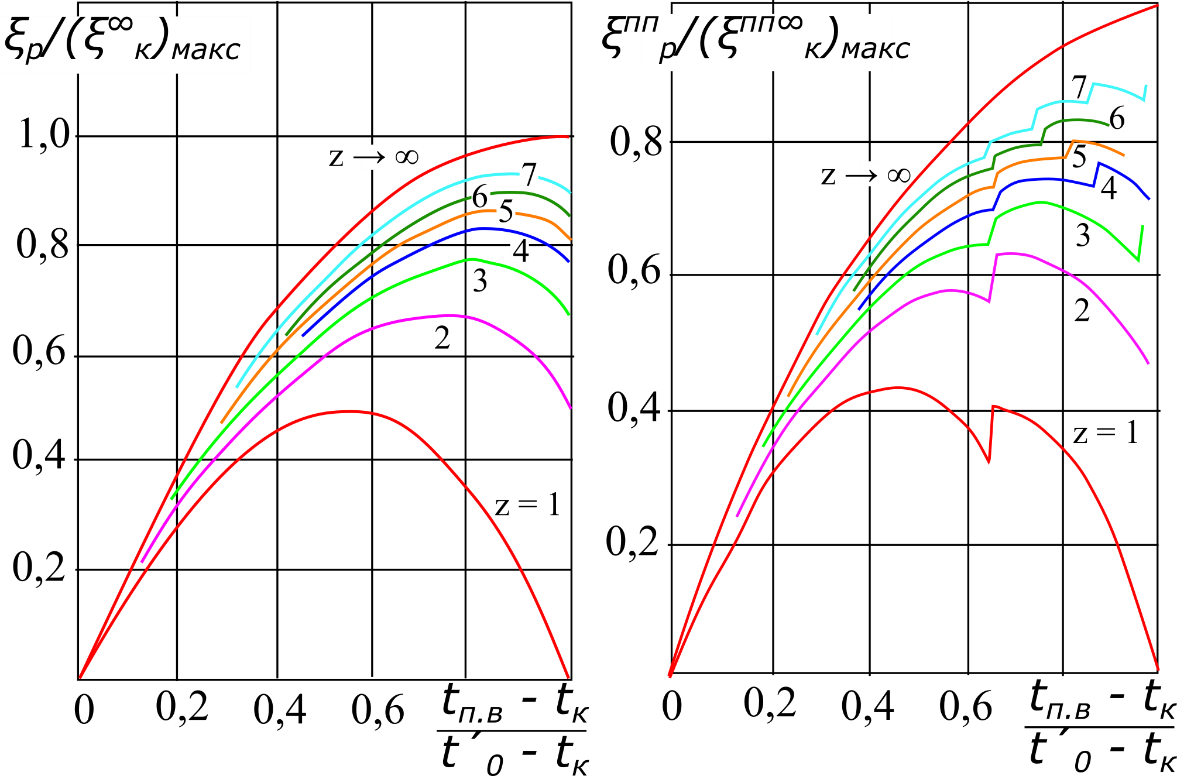

$t_0'$ – температура насыщения при давлении свежего пара р0 (при сверхкритическом давлении принять $t_0'$=374,2 С

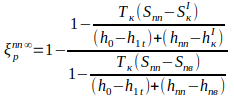

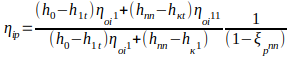

In [3]:
electrical_power = 180 * (10 ** 6)
p0 = 12.8 * MPa
t0 = 540
p_middle = 2.49 * MPa
t_middle = 540
pk = 6.27 * kPa
t_feed_water = 248
p_feed_water = 1.4 * p0
z = 7

internal_efficiency = 0.85
mechanical_efficiency = 0.994
generator_efficiency = 0.99

In [4]:
delta_p0 = 0.05 * p0
delta_p_middle = 0.1 * p_middle
delta_p_1 = 0.03 * p_middle


real_p0 = p0 - delta_p0
real_p1t = p_middle + delta_p_middle
real_p_middle = p_middle - delta_p_1

In [5]:
_point_0 = gas(P = p0 * unit, T=to_kelvin(t0))
point_0 = gas(P=real_p0 * unit, h=_point_0.h)
point_1t = gas(P=real_p1t * unit, s=_point_0.s)

hp_heat_drop = (_point_0.h - point_1t.h) * internal_efficiency
h_1 = point_0.h - hp_heat_drop
point_1 = gas(P=real_p1t * unit, h=h_1)

In [6]:
_point_middle = gas(P=p_middle * unit, T=to_kelvin(t_middle))
point_middle = gas(P=real_p_middle * unit, h=_point_middle.h)
point_2t = gas(P=pk * unit, s=_point_middle.s)

lp_heat_drop = (_point_middle.h - point_2t.h) * internal_efficiency
h_2 = point_middle.h - lp_heat_drop
point_2 = gas(P=pk * unit, h=h_2)

efficiency_hp = (_point_0.h - point_1.h) / (_point_0.h - point_1t.h)
efficiency_lp = (_point_middle.h - point_2.h) / (_point_middle.h - point_2t.h)
efficiency_hp, efficiency_lp

(0.8499999999999992, 0.8500000000000011)

In [7]:
point_k_water = gas(P=pk * unit, x=0)

point_feed_water = gas(P=p_feed_water * unit, T=to_kelvin(t_feed_water))

In [8]:
numenator_without = point_2.T * (_point_middle.s - point_k_water.s)
denumenator_without = (point_0.h - point_1t.h) + (point_middle.h - point_k_water.h)
without_part = 1 - (numenator_without / denumenator_without)


numenator_infinity = point_2.T * (_point_middle.s - point_feed_water.s)
denumenator_infinity = (point_0.h - point_1t.h) + (point_middle.h - point_feed_water.h)
infinity_part = 1 - (numenator_infinity / denumenator_infinity)

ksi_infinity = 1 - (without_part / infinity_part)
ksi_infinity

0.11742639190605841

In [9]:
coeff = (point_feed_water.T - point_2.T) / (to_kelvin(374.2) - point_2.T)
coeff

0.6257798438596769

In [10]:
ksi = 0.83 * ksi_infinity
ksi

0.09746390528202847

In [11]:
eff_num = hp_heat_drop + lp_heat_drop
eff_denum = hp_heat_drop + (point_middle.h - point_k_water.h)

efficiency = (eff_num / eff_denum) * (1 / (1 - ksi))
efficiency

0.4247469105926106

In [12]:
estimated_heat_drop = efficiency * ((point_0.h - point_feed_water.h) + (point_middle.h - point_1.h))
estimated_heat_drop

1213.5688860152318

In [13]:
inlet_mass_flow = electrical_power / (estimated_heat_drop * 1000 * mechanical_efficiency * generator_efficiency)
inlet_mass_flow

150.72541656372567

In [14]:
condenser_mass_flow = (
    electrical_power /
    ((point_2.h - point_k_water.h) * 1000 * mechanical_efficiency * generator_efficiency) * ((1 / efficiency) - 1)
)
condenser_mass_flow

106.30068416558679

In [15]:
print("Массовый расход в турбину на входе", inlet_mass_flow)

Массовый расход в турбину на входе 150.72541656372567


In [16]:
print("Массовый расход в конденсатор:", condenser_mass_flow)

Массовый расход в конденсатор: 106.30068416558679
